In [1]:
import kagglehub
import os
import sys
import pandas as pd 
import numpy as np
import torch 
from matplotlib import pyplot as plt

from transformers import AutoTokenizer, AutoModel

/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("blk1804/kiba-drug-binding-dataset")
print("Path to dataset files:", path)

Path to dataset files: /home/teddy/.cache/kagglehub/datasets/blk1804/kiba-drug-binding-dataset/versions/1


In [3]:
kiba = pd.read_csv(os.path.join(path, "KIBA.csv"))
kiba.head()

,CHEMBLID,ProteinID,compound_iso_smiles,target_sequence,"Ki , Kd and IC50 (KIBA Score)"
0,CHEMBL373751,P53350,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...,0.0
1,CHEMBL373751,P00533,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,1.1
2,CHEMBL373751,P04626,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,1.1
3,CHEMBL373751,P49840,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGGGPSGGGPGGSGRARTSSFAEPGGGGGGGGGGPGGSASGPGGT...,1.3
4,CHEMBL373751,P49841,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,1.3


In [4]:
drugs = kiba[['CHEMBLID', 'compound_iso_smiles']].drop_duplicates()
prots = kiba[['ProteinID', 'target_sequence']].drop_duplicates()

print("Number of drugs:", len(drugs))
print("Number of proteins:", len(prots))

drug2idx = {d: i for i, d in enumerate(drugs['CHEMBLID'])}
prot2idx = {p: i for i, p in enumerate(prots['ProteinID'])}

kiba = kiba.assign(drug_idx=kiba['CHEMBLID'].map(drug2idx))
kiba = kiba.assign(prot_idx=kiba['ProteinID'].map(prot2idx))
kiba.head()

Number of drugs: 2111
Number of proteins: 229


,CHEMBLID,ProteinID,compound_iso_smiles,target_sequence,"Ki , Kd and IC50 (KIBA Score)",drug_idx,prot_idx
0,CHEMBL373751,P53350,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...,0.0,0,0
1,CHEMBL373751,P00533,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...,1.1,0,1
2,CHEMBL373751,P04626,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...,1.1,0,2
3,CHEMBL373751,P49840,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGGGPSGGGPGGSGRARTSSFAEPGGGGGGGGGGPGGSASGPGGT...,1.3,0,3
4,CHEMBL373751,P49841,COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...,MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...,1.3,0,4


In [5]:
model_name = "seyonec/ChemBERTa-zinc-base-v1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).cuda()

smiles = drugs['compound_iso_smiles'].values.tolist()
max_len = 512
print("Max length of SMILES:", max_len)

inputs = tokenizer(
    smiles,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=max_len  # Adjust max_length as needed
)

batch_size = 500
outputs = []

with torch.no_grad():

    for i in range(0, len(smiles), batch_size):
        batch_inputs = {k: v[i:i+batch_size].cuda() for k, v in inputs.items()}
        batch_outputs = model(**batch_inputs)
        outputs.append(batch_outputs.last_hidden_state[:, 0, :])

# Concatenate all batch outputs
z_drug = torch.cat(outputs, dim=0)

print(z_drug.shape)

Max length of SMILES: 512
torch.Size([2111, 768])


In [6]:
aas = prots['target_sequence'].values.tolist()

model_name = "Rostlab/prot_bert"

tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
model = AutoModel.from_pretrained(model_name)

def prepare_sequence(seq):
    seq = ' '.join(list(seq))
    return f"[CLS] {seq} [SEP]"

sequences_prepared = [prepare_sequence(seq) for seq in aas]

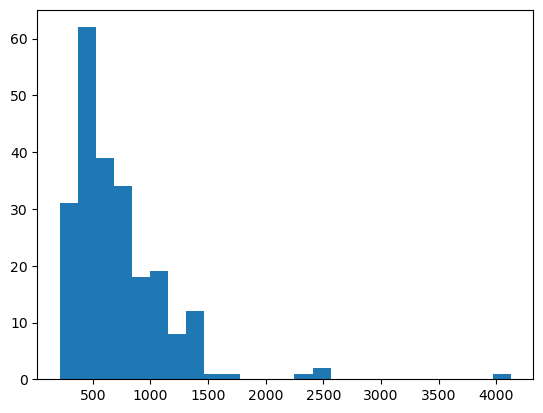

In [7]:
plt.figure()
plt.hist([len(aa) for aa in aas], bins=25)
plt.show()

max_len = 1500

In [8]:
inputs = tokenizer(
    sequences_prepared,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=max_len  # Adjust as needed
)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: value.to(device) for key, value in inputs.items()}

batch_size = 32
outputs = []
for i in range(0, len(inputs['input_ids']), batch_size):
    print(f'progress: {i}/{len(inputs["input_ids"])}', end='\r')
    batch_inputs = {key: value[i:i+batch_size] for key, value in inputs.items()}
    with torch.no_grad():
        batch_outputs = model(**batch_inputs)
    outputs.append(batch_outputs.last_hidden_state[:, 0, :])
    
z_prot = torch.cat(outputs, dim=0)
print(z_prot.shape)

torch.Size([229, 1024])


In [10]:
os.makedirs("../../extdata/kiba", exist_ok=True)
kiba.to_csv("../../extdata/kiba/kiba.csv", index=False)
drugs.to_csv("../../extdata/kiba/drugs.csv", index=False)
prots.to_csv("../../extdata/kiba/prots.csv", index=False)
torch.save(z_drug, "../../extdata/kiba/z_drug.pt")
torch.save(z_prot, "../../extdata/kiba/z_prot.pt")